# Hackathon IBM 2025 - Track Finance - Training Models- Group 19

Lina Lagzouli
Harrisson TEVOEDJRE
Ines Difri
Lamia Ladraa
Mouslimah Diop
Myriam Ait Said


Dans cette partie du projet, nous testons différents modèles de classification afin de prédire les transactions frauduleuses. Nous évaluons plusieurs stratégies de rééquilibrage des données, notamment SMOTE, Borderline-SMOTE, ainsi que des tests avec et sans PCA, afin d’améliorer la détection de la classe minoritaire.

Toute la phase d’EDA, de nettoyage, et de préparation des données ayant déjà été réalisée dans les autres notebooks de notre GitHub, nous réutilisons ici directement les données propres et prêtes pour la modélisation. Cela nous permet de nous concentrer exclusivement sur les expérimentations de modèles (SVM, Random Forest, AdaBoost, XGBoost, etc.) et l’analyse de leurs performances selon différentes stratégies de rééquilibrage.

## Librairies import

In [1]:
import numpy as np
import pandas as pd
import csv
import json
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, f1_score, recall_score, precision_score,confusion_matrix, ConfusionMatrixDisplay)
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE


In [2]:
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

## Merge of the train data

In [4]:
transactions = pd.read_csv("transactions_train_cleaned.csv")
labels = pd.read_json("train_fraud_labels.json")

In [ ]:
transactions = pd.read_csv("transactions_train_cleaned.csv")
labels = pd.read_json("train_fraud_labels.json")
cards = pd.read_csv("cards_data_cleaned.csv")
users = pd.read_csv("users_data_cleaned.csv")
with open("mcc_codes.json", "r") as f:
    mcc_codes = json.load(f)

mcc = pd.DataFrame(
    list(mcc_codes.items()),
    columns=["mcc", "mcc_description"]
)


In [5]:
labels = labels.reset_index()
labels = labels.rename(columns={"index": "transaction_id"})
labels["target"] = labels["target"].map({"Yes": 1, "No": 0})
labels.head()

,transaction_id,target
0,19765990,0
1,22160255,0
2,17566794,0
3,17318690,0
4,20994060,0


In [6]:
df = transactions.merge(labels, on="transaction_id", how="left")

In [ ]:
users = users.rename(columns={"id": "client_id"})
df = df.merge(users, on="client_id", how="left")

In [ ]:
cards = cards.rename(columns={"id": "card_id"})
df = df.merge(cards, on="card_id", how="left")

In [ ]:
df["mcc"] = df["mcc"].astype(str)
mcc["mcc"] = mcc["mcc"].astype(str)
df = df.merge(mcc, on="mcc", how="left")


## Data transfrormations

Dans cette section, nous appliquons les conversions de types et le prétraitement essentiel pour rendre les données directement exploitables par nos modèles (gestion des valeurs manquantes, encodage, formats numériques). L’EDA et le nettoyage complet ayant déjà été réalisés dans les autres notebooks, nous réutilisons ici uniquement les données déjà propres.

In [16]:
df['merchant_state'] = df['merchant_state'].fillna('online')
df['zip'] = df['zip'].fillna('99999')
df['errors'] = df['errors'].fillna('no')



# --- Conversion en datetime ---
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['expires'] = pd.to_datetime(df['expires'], errors='coerce')
df['date_only'] = pd.to_datetime(df['date_only'], errors='coerce')
df['acct_open_date'] = pd.to_datetime(df['acct_open_date'], errors='coerce')

# --- Colonnes catégorielles ---
categorical_cols = ['card_type', 'card_brand', 'errors']

# Mapping automatique vers des nombres
for col in categorical_cols:
    df[col] = df[col].astype('category')
    df[col + '_num'] = df[col].cat.codes  # création d'une colonne numérique

# --- Colonnes restantes en string (non utilisées pour corrélation) ---
#cols_string = ['use_chip', 'merchant_city', 'merchant_state', 'address', 'mcc_description']
cols_string = ['use_chip', 'merchant_city', 'merchant_state']
df[cols_string] = df[cols_string].astype('string')

# --- Vérification ---
print(df.head())
print(df.dtypes)
#%%
df['date_num'] = df['date'].view('int64')  # nombre de nanosecondes depuis 1970
df['expires_num'] = df['expires'].view('int64')
df['date_only_num'] = df['date_only'].view('int64')
df['acct_open_date_num'] = df['acct_open_date'].view('int64')

   transaction_id                date  client_id  card_id  amount  \
0        19765990 2017-07-07 09:53:00       1581     2519   12.35   
1        22160255 2018-11-26 17:44:00       1862     4049   58.29   
2        17566794 2016-03-26 12:42:00       1967     3367   11.03   
3        17318690 2016-02-01 08:30:00        921     3457   85.74   
4        20994060 2018-03-24 14:42:00        456     2800   13.43   

           use_chip  merchant_id merchant_city merchant_state      zip   mcc  \
0  Chip Transaction        20519        Arnold             MO  63010.0  5942   
1  Chip Transaction        98648    Des Moines             IA  50313.0  5814   
2  Chip Transaction        46978   Lake Forest             CA  92630.0  5411   
3  Chip Transaction        63701          Rush             NY  14543.0  5411   
4  Chip Transaction        83271        Estero             FL  33928.0  4214   

  errors  date_only  target  errors_num             date_num  \
0     no 2017-07-07       0          16 

/tmp/ipython-input-2712143196.py:31: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df['date_num'] = df['date'].view('int64')  # nombre de nanosecondes depuis 1970
/tmp/ipython-input-2712143196.py:33: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df['date_only_num'] = df['date_only'].view('int64')


In [22]:
string_cols = ['use_chip', 'merchant_city', 'merchant_state']

df[string_cols] = df[string_cols].astype("string")


# --- 2) Conversion des dates ---
date_cols = ['date',  'date_only']

for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    df[col + "_num"] = df[col].view("int64")   # conversion 0→1970 en nanosecondes


# --- 3) Colonnes catégorielles → numériques ---
categorical_cols = [ 'errors']

for col in categorical_cols:
    df[col] = df[col].astype("category")
    df[col + "_num"] = df[col].cat.codes


# 4) On supprime les colonnes non numériques pour éviter les erreurs de scaler
to_drop = categorical_cols + string_cols + date_cols

df = df.drop(columns=to_drop)

print(df.dtypes)
df.head()

transaction_id      int64
client_id           int64
card_id             int64
amount            float64
merchant_id         int64
zip                object
mcc                 int64
target              int64
errors_num           int8
date_num            int64
date_only_num       int64
dtype: object


/tmp/ipython-input-919208100.py:11: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df[col + "_num"] = df[col].view("int64")   # conversion 0→1970 en nanosecondes
/tmp/ipython-input-919208100.py:11: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df[col + "_num"] = df[col].view("int64")   # conversion 0→1970 en nanosecondes


,transaction_id,client_id,card_id,amount,merchant_id,zip,mcc,target,errors_num,date_num,date_only_num
0,19765990,1581,2519,12.35,20519,63010.0,5942,0,16,1499421180000000000,1499385600000000000
1,22160255,1862,4049,58.29,98648,50313.0,5814,0,16,1543254240000000000,1543190400000000000
2,17566794,1967,3367,11.03,46978,92630.0,5411,0,16,1458996120000000000,1458950400000000000
3,17318690,921,3457,85.74,63701,14543.0,5411,0,16,1454315400000000000,1454284800000000000
4,20994060,456,2800,13.43,83271,33928.0,4214,0,16,1521902520000000000,1521849600000000000


## Data scaling

In [23]:
X = df.drop(columns=["target","zip"])
y = df["target"]

scaler = StandardScaler().set_output(transform="pandas")

X = scaler.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Inbalanced data

Total count: 210000
Fraud count: 315 (0.15%)
Non-fraud count: 209685 (99.85%)


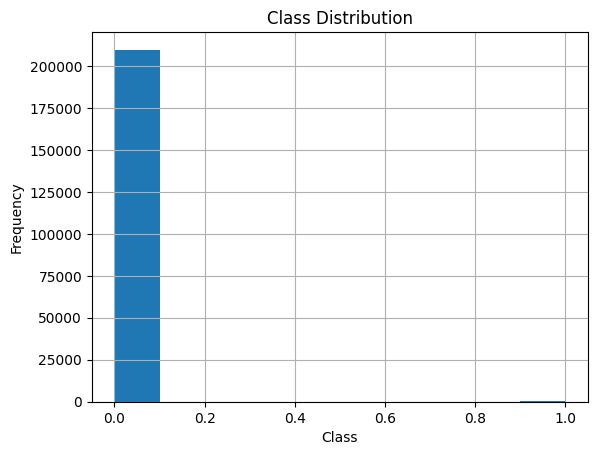

In [ ]:
# --- Quantify imbalance ---
total_count = len(y)

fraud_count = y.sum()                  # nombre de 1
non_fraud_count = total_count - fraud_count

fraud_percentage = (fraud_count / total_count) * 100
non_fraud_percentage = (non_fraud_count / total_count) * 100

print(f"Total count: {total_count}")
print(f"Fraud count: {fraud_count} ({fraud_percentage:.2f}%)")
print(f"Non-fraud count: {non_fraud_count} ({non_fraud_percentage:.2f}%)")


# --- Visualize imbalance ---
df['target'].hist()
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

La distribution montre un déséquilibre extrême : sur 210 000 transactions, seules 315 sont frauduleuses (0,15 %). La classe non-fraude représente donc 99,85 % des données, rendant la détection des fraudes très difficile sans techniques de rééquilibrage.

In [24]:
# create a first copy of x_train
x_train1 = x_train.copy()

# Create a balanced set x_train2 using SMOTE
smote = SMOTE(random_state=0)
x_train2, y_train2 = smote.fit_resample(x_train, y_train)

# Create an other balanced set x_train3 using Borderline SMOTE
b_smote = BorderlineSMOTE(random_state=0)
x_train3, y_train3 = b_smote.fit_resample(x_train, y_train)

## Modèles

In [25]:
def evaluate_model(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)

    print(f"\n{model_name}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"Precision: {prec:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])
    disp.plot(cmap='plasma')
    plt.title(f"{model_name}")
    plt.show()

On conserve d’abord une version originale de x_train, puis nous générons deux jeux d’entraînement rééquilibrés : l’un avec SMOTE, l’autre avec Borderline-SMOTE, afin de comparer l’impact de différentes méthodes de sur-échantillonnage sur les performances des modèles.

###Random Forest

Nous avons choisi d’inclure Random Forest car c’est un modèle robuste, capable de gérer naturellement les données bruitées et les interactions complexes entre variables. Il fonctionne bien sur de nombreux types de datasets, même sans réglages avancés, et sert souvent de bon point de comparaison grâce à sa stabilité, sa résistance au sur-apprentissage et sa capacité à donner des résultats fiables sur des problèmes de classification difficiles comme la détection de fraude.


Random Forest - Cost-Sensitive
Accuracy:  0.9985
F1-score:  0.0000
Recall:    0.0000
Precision: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


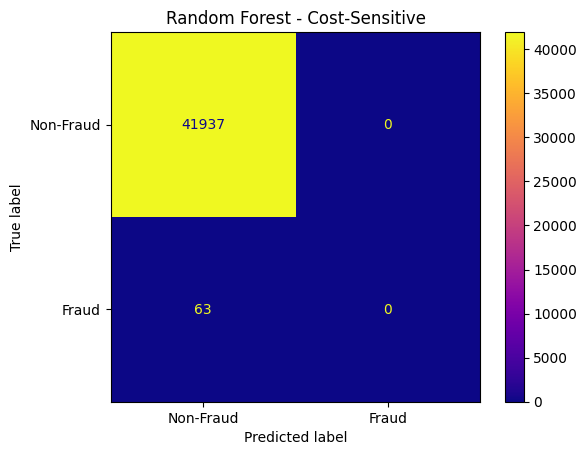

In [37]:
model_rf = RandomForestClassifier(class_weight='balanced', random_state=42)
model_rf.fit(x_train1, y_train)

y_pred_rf = model_rf.predict(x_test)
evaluate_model(y_test, y_pred_rf, "Random Forest - Cost-Sensitive")

Le Random Forest sensible au coût obtient une excellente accuracy, mais ne détecte aucune fraude : le modèle prédit uniquement la classe majoritaire. La matrice de confusion montre 0 fraude identifiée (Recall = 0 %), ce qui confirme que le modèle reste totalement biaisé par le déséquilibre extrême du dataset.


Random Forest - SMOTE
Accuracy:  0.9974
F1-score:  0.0992
Recall:    0.0952
Precision: 0.1034


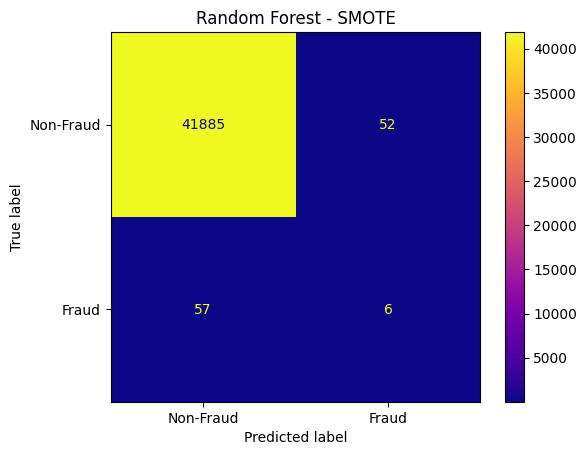

In [38]:
# Random Forest - SMOTE Balanced Data
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(x_train2, y_train2)

y_pred_rf_smote = model_rf.predict(x_test)
evaluate_model(y_test, y_pred_rf_smote, "Random Forest - SMOTE")

Avec SMOTE, le Random Forest commence enfin à détecter quelques fraudes : le recall passe à 9,5 % (6 fraudes trouvées). Cependant, le modèle génère beaucoup de faux positifs, ce qui dégrade la précision. La matrice de confusion montre donc une légère amélioration de la détection, mais le modèle reste globalement insuffisant face au déséquilibre extrême du dataset.


Random Forest - B-SMOTE
Accuracy:  0.9984
F1-score:  0.0000
Recall:    0.0000
Precision: 0.0000


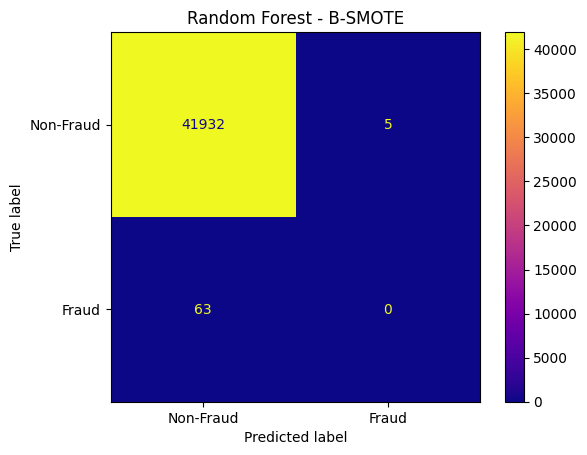

In [ ]:
# Random Forest - B-SMOTE Balanced Data
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(x_train3, y_train3)

y_pred_rf_bsmote = model_rf.predict(x_test)
evaluate_model(y_test, y_pred_rf_bsmote, "Random Forest - B-SMOTE")

Avec Borderline-SMOTE, le modèle reste incapable de détecter les fraudes (recall = 0 %). Malgré un léger bruit ajouté sur la classe majoritaire, aucune amélioration n’est observée : la Random Forest prédit uniquement les transactions non frauduleuses, confirmant que cette méthode de suréchantillonnage n’est pas efficace sur ce dataset extrêmement déséquilibré.

###Linear SVM

Nous choisissons d’inclure le Linear SVM car c’est un modèle particulièrement adapté aux données à haute dimension et aux problèmes de classification avec une classe minoritaire. Il est souvent performant pour trouver une frontière de décision simple mais efficace, ce qui en fait un bon candidat pour améliorer la détection des fraudes dans un dataset fortement déséquilibré.


Linear SVM - SMOTE
Accuracy:  0.7216
F1-score:  0.0061
Recall:    0.5714
Precision: 0.0031


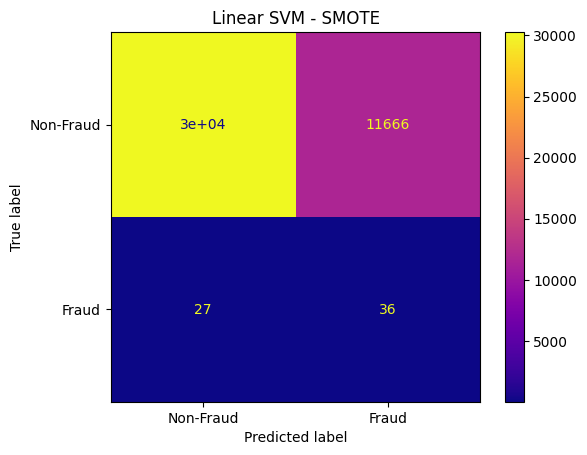

In [39]:
# Linear SVM - SMOTE Balanced Data
model_svm = LinearSVC(random_state=42, max_iter=10000)
model_svm.fit(x_train2, y_train2)

y_pred_svm_smote = model_svm.predict(x_test)

evaluate_model(y_test, y_pred_svm_smote, "Linear SVM - SMOTE")


Avec SMOTE, le SVM linéaire parvient enfin à détecter une partie significative des fraudes : le recall atteint 57 % (36 fraudes identifiées). En contrepartie, il génère un très grand nombre de faux positifs, ce qui fait chuter la précision et l’accuracy. La matrice de confusion montre donc un modèle très sensible mais peu fiable, typique d’un SVM sur-déséquilibré après sur-échantillonnage.


Linear SVM - B-SMOTE
Accuracy:  0.9102
F1-score:  0.0152
Recall:    0.4603
Precision: 0.0077


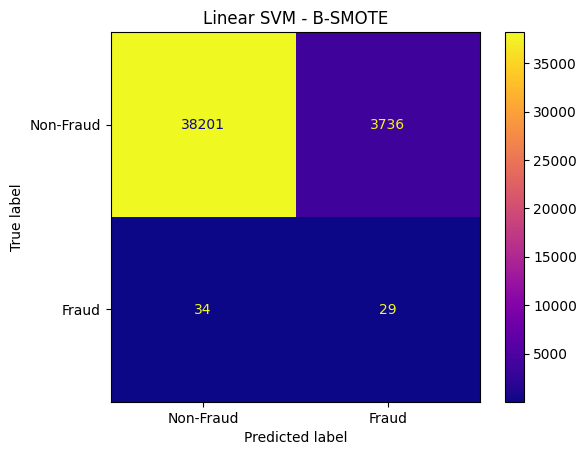

In [40]:
# SVM - B-SMOTE Balanced Data
model_svm = LinearSVC(random_state=42, max_iter=10000)
model_svm.fit(x_train3, y_train3)

# Prédictions
y_pred_svm_bsmote = model_svm.predict(x_test)

# Évaluation du modèle
evaluate_model(y_test, y_pred_svm_bsmote, "Linear SVM - B-SMOTE")


Avec Borderline-SMOTE, le SVM linéaire détecte moins de fraudes qu'avec SMOTE (recall ≈ 46 %), mais produit beaucoup moins de faux positifs. L’accuracy augmente nettement, mais la précision reste faible. Ce compromis montre que B-SMOTE rend le modèle un peu plus stable, au prix d’une sensibilité légèrement réduite

### AdaBoost et XGBoost

Nous testons également AdaBoost et XGBoost, car ce sont deux modèles de boosting reconnus pour leur capacité à capturer des relations complexes et à bien performer sur des problèmes difficiles. Nous les évaluons avec et sans PCA, et avec ou sans SMOTE, afin de voir si la réduction de dimension facilite la séparation entre les classes et si le rééquilibrage améliore la détection de la classe minoritaire.

In [41]:
counts = Counter(y_train)
neg, pos = counts[0], counts[1]
pos_weight = neg / max(1, pos)

In [28]:
def make_pipeline(use_smote=False, use_pca=False, clf=None):
    steps = []
    steps.append(("scaler", StandardScaler()))                 # toujours scaler
    steps.append(("smote", SMOTE(random_state=0) if use_smote else "passthrough"))
    steps.append(("pca", PCA(n_components=0.90, random_state=0) if use_pca else "passthrough"))
    steps.append(("clf", clf))
    return ImbPipeline(steps)

In [29]:
def make_pipeline(use_smote=False, use_pca=False, clf=None):
    steps = []
    steps.append(("scaler", StandardScaler()))                 # toujours scaler
    steps.append(("smote", SMOTE(random_state=0) if use_smote else "passthrough"))
    steps.append(("pca", PCA(n_components=0.90, random_state=0) if use_pca else "passthrough"))
    steps.append(("clf", clf))
    return ImbPipeline(steps)

In [30]:
base_tree = DecisionTreeClassifier(max_depth=1, class_weight={0:1.0, 1:pos_weight}, random_state=42)
ada = AdaBoostClassifier(estimator=base_tree, n_estimators=200, learning_rate=0.5, random_state=42)

In [31]:
xgb = XGBClassifier(
        n_estimators=300, max_depth=4, learning_rate=0.1,
        subsample=0.9, colsample_bytree=0.9,
        objective="binary:logistic", eval_metric="logloss",
        scale_pos_weight=pos_weight, random_state=42, n_jobs=-1
    )

In [32]:
cases = [
    (False, False, "NoBal | NoPCA"),
    (False, True,  "NoBal | PCA90"),
    (True,  False, "SMOTE | NoPCA"),
    (True,  True,  "SMOTE | PCA90"),
]


AdaBoost | NoBal | NoPCA
Accuracy:  0.9249
F1-score:  0.0150
Recall:    0.3810
Precision: 0.0076


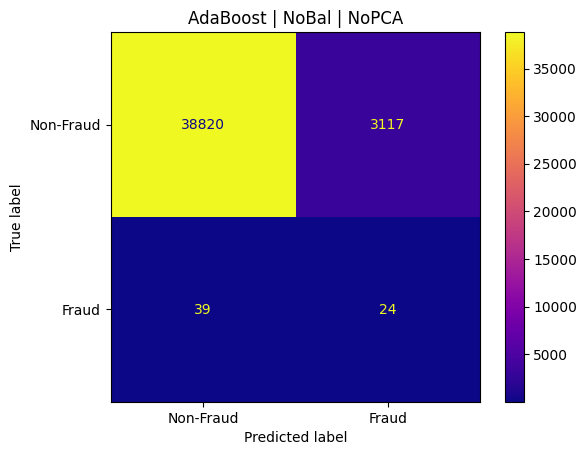


AdaBoost | NoBal | PCA90
Accuracy:  0.9104
F1-score:  0.0131
Recall:    0.3968
Precision: 0.0067


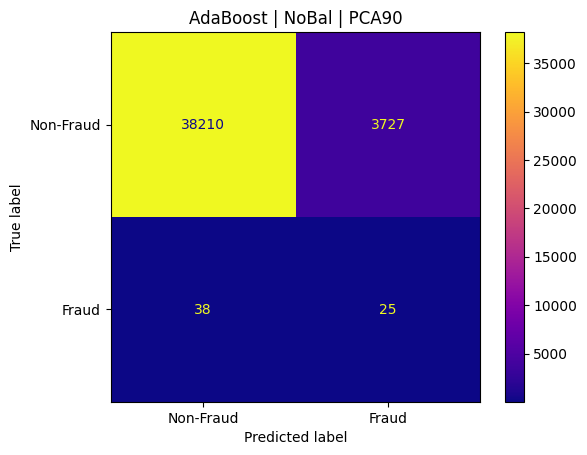


AdaBoost | SMOTE | NoPCA
Accuracy:  0.0196
F1-score:  0.0030
Recall:    0.9841
Precision: 0.0015


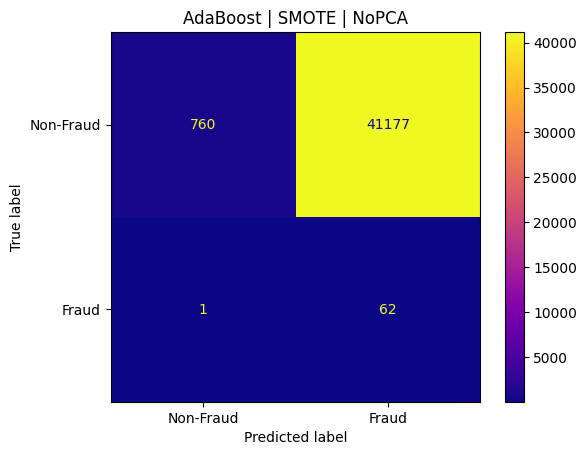


AdaBoost | SMOTE | PCA90
Accuracy:  0.0206
F1-score:  0.0030
Recall:    0.9683
Precision: 0.0015


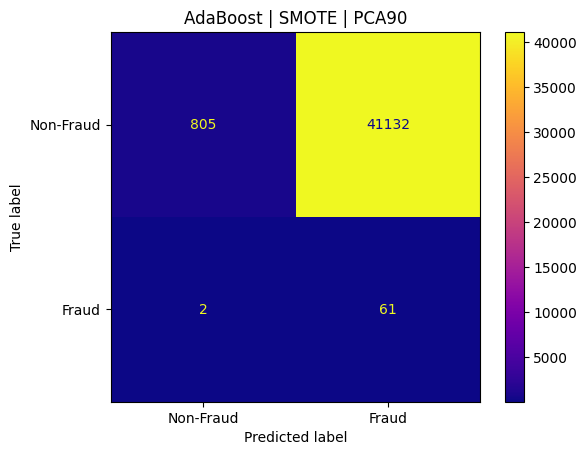

In [36]:
for use_smote, use_pca, tag in cases:
    pipe = make_pipeline(use_smote=use_smote, use_pca=use_pca, clf=ada)
    pipe.fit(x_train, y_train)
    y_pred = pipe.predict(x_test)
    evaluate_model(y_test, y_pred, f"AdaBoost | {tag}")

Sans rééquilibrage (avec ou sans PCA), AdaBoost arrive à détecter une partie des fraudes, mais son recall reste limité et il génère encore beaucoup de faux positifs. L’ajout de PCA ne change presque rien : les performances restent similaires.

En revanche, dès qu’on active SMOTE, le comportement d’AdaBoost change complètement. Le modèle devient beaucoup plus sensible à la classe fraude, avec un recall qui dépasse 96 %. Par contre, il prédit presque toutes les transactions comme frauduleuses, ce qui fait exploser le nombre de faux positifs et fait chuter l’accuracy. Cela montre qu’AdaBoost est très instable sur un dataset aussi déséquilibré et qu’il réagit fortement au sur-échantillonnage.


XGBoost | NoBal | NoPCA
Accuracy:  0.9771
F1-score:  0.0456
Recall:    0.3651
Precision: 0.0243


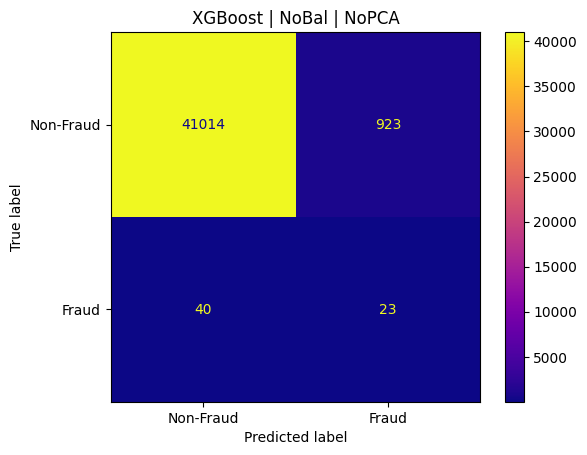

Modèle sauvegardé : xgboost_smote_pca90_NoBal | NoPCA.joblib

XGBoost | NoBal | PCA90
Accuracy:  0.9682
F1-score:  0.0162
Recall:    0.1746
Precision: 0.0085


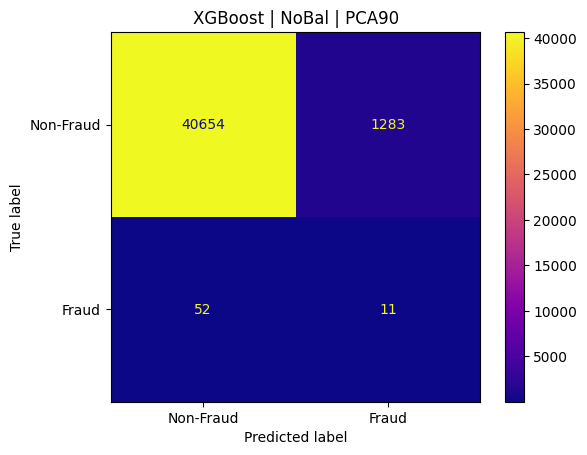

Modèle sauvegardé : xgboost_smote_pca90_NoBal | PCA90.joblib

XGBoost | SMOTE | NoPCA
Accuracy:  0.6922
F1-score:  0.0068
Recall:    0.6984
Precision: 0.0034


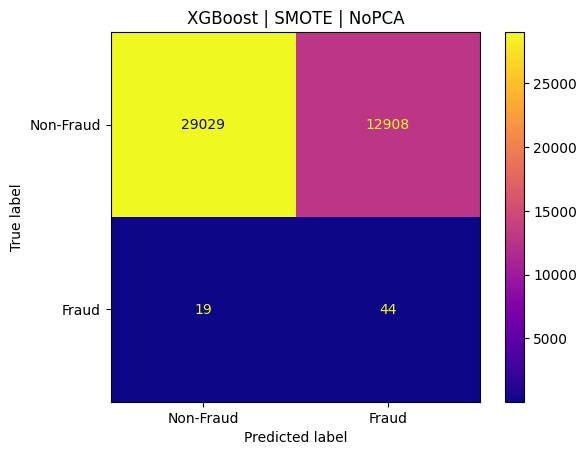

Modèle sauvegardé : xgboost_smote_pca90_SMOTE | NoPCA.joblib

XGBoost | SMOTE | PCA90
Accuracy:  0.4463
F1-score:  0.0037
Recall:    0.6825
Precision: 0.0018


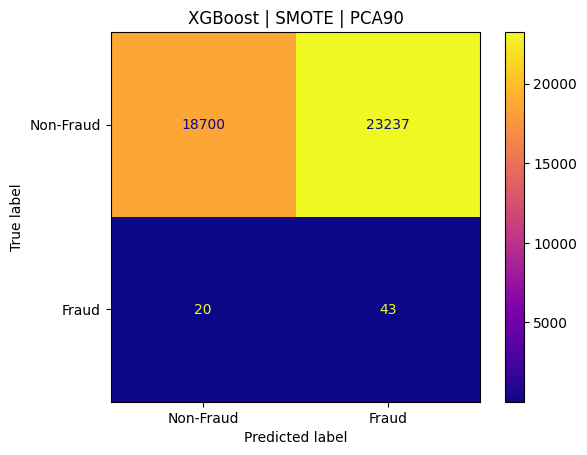

Modèle sauvegardé : xgboost_smote_pca90_SMOTE | PCA90.joblib


In [35]:
from joblib import dump
for use_smote, use_pca, tag in cases:
    pipe = make_pipeline(use_smote=use_smote, use_pca=use_pca, clf=xgb)
    pipe.fit(x_train, y_train)
    y_pred = pipe.predict(x_test)
    evaluate_model(y_test, y_pred, f"XGBoost | {tag}")

    # Sauvegarde du modèle entraîné
    dump(pipe, f"xgboost_smote_pca90_{tag}.joblib")
    print(f"Modèle sauvegardé : xgboost_smote_pca90_{tag}.joblib")


Sans rééquilibrage, XGBoost parvient déjà à détecter une partie des fraudes, avec un recall autour de 36 %, ce qui est supérieur à la plupart des modèles précédemment testés. En revanche, l’ajout de la PCA sans SMOTE réduit la sensibilité du modèle, ce qui montre que la réduction de dimension retire certaines informations importantes pour la détection.

Avec SMOTE, les performances d’XGBoost s’améliorent nettement : le recall monte à près de 70 %, ce qui représente l’un des meilleurs scores obtenus dans toute notre étude. Le modèle devient clairement plus efficace pour repérer la classe minoritaire, et parvient à identifier une grande partie des fraudes présentes dans le dataset. L’association SMOTE + PCA reproduit ce comportement, avec une forte sensibilité mais une précision plus faible.

Au final, XGBoost réagit particulièrement bien au sur-échantillonnage, et la configuration XGBoost + SMOTE (sans PCA) apparaît comme la plus pertinente pour notre objectif : maximiser la détection des fraudes, en atteignant un recall proche de 70 % sur un dataset extrêmement déséquilibré. Cette performance constitue une base solide pour une solution opérationnelle de détection de fraude.

##Conclusion

XGBoost combiné à SMOTE (sans PCA) s’est révélé être le modèle le plus performant pour notre objectif, avec le meilleur recall et une capacité nettement renforcée à détecter les fraudes. Ce résultat est particulièrement encourageant compte tenu du déséquilibre extrême du dataset. Le modèle parvient à identifier une grande partie des transactions frauduleuses, ce qui constitue un excellent point de départ pour une solution de détection opérationnelle.

La prochaine étape consistera à comparer ces performances avec celles obtenues sur Watsonx, où plusieurs modèles ont été évalués automatiquement. Cette comparaison permettra de confirmer la solidité de notre approche et de sélectionner la solution la plus efficace et la plus cohérente pour la détection de fraudes.